#### Problem Statement

The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.

Suppose you are working as a Machine Learning Engineer/Data Scientist in an e-commerce company named 'E-Com'. E-Com has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

With the advancement in technology, it is imperative for E-Com to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a Data Scientis/ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings.

In order to do this, you planned to build a sentiment-based product recommendation system, which includes the following tasks.

Data sourcing and sentiment analysis Building a recommendation system Improving the recommendations using the sentiment analysis model Deploying the end-to-end project with a user interface


### High Level steps 

* Data Sourcing and Sentiment Analysis

* Building a recommendation system

* Improving the recommendation system using sentiment analysis model

* Deploying the end-to-end project with user interface


In [16]:
# !pip install pyspellchecker

In [1]:
# Import general purpose libraries 
import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import warnings

# Import Pre-Processing Tools
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
warnings.filterwarnings("ignore") 

# Set Pandas options
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)
pd.set_option("display.precision", 2)

In [ ]:
# nltk packages
import nltk
import ssl

""" Download all nltk packages through external ssl"""
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')



In [10]:
# nltk libraries
from nltk.corpus import stopwords 
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn

In [12]:
# ML Modelling Libraries

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [24]:
# import sklearn
# print(sklearn.__version__) #1.0.2
# print(np.__version__) #1.22.4
# print(pd.__version__) #1.3.5
# print(nltk.__version__) #3.8.1

In [25]:
import os
cwd = os.getcwd()
df_reviews = pd.read_csv(cwd + "/user_reviews.csv")
df_reviews.shape

(30000, 15)

In [26]:
#Inspect the dataframe to understand the given data
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

* There are many columns with NULL values, we will handle them later.
* First step is to eliminate some columns as part of our analysis for Sentiment and Recommender models.We will inspect them and remove them later.

In [27]:
df_reviews.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


### Exploratory Data Analysis - Data Cleaning and Pre-Processing

In [51]:
def calc_missing_rowcount(df):
    columns = df.columns
    null_count = [df[col].isnull().sum() for col in columns]
    null_perc = [round((val/df.shape[0]) * 100,2) for val in null_count]
    _df = pd.DataFrame({'Columns':np.array(columns),
                        'Count': np.array(null_count),
                        'Percent':np.array(null_perc)})
    # If round is not an option, formatting options in pandas and numpy will 
    # pd.options.display.float_format = '{:.2f}'.format
    # np.set_printoptions(suppress=True)
                            
    return _df.sort_values("Percent",ascending=False)
calc_missing_rowcount(df_reviews)



,Columns,Count,Percent
12,reviews_userProvince,29830,99.43
11,reviews_userCity,28071,93.57
6,reviews_didPurchase,14068,46.89
7,reviews_doRecommend,2570,8.57
10,reviews_title,190,0.63
3,manufacturer,141,0.47
13,reviews_username,63,0.21
5,reviews_date,46,0.15
0,id,0,0.00
1,brand,0,0.00


#### Observations:
**reviews_userProvince** and **reviews_userCity** have over 93% NULL values and are not useful for analysis. We will remove them from the dataset.

**reviews_didPurchase** column has over 46% NULL values. This field is not useful in building either Sentiment/Recommender system as well and will be removed.

Removing reviews_userProvince, reviews_userCity and reviews_didPurchase from the dataset¶


In [52]:
df_clean = df_reviews.copy()
df_clean.drop(columns=['reviews_userProvince','reviews_userCity','reviews_didPurchase'],
                inplace=True)
df_clean.shape

(30000, 12)

Checking reviews_doRecommend column¶


In [57]:
print(df_clean.reviews_doRecommend.value_counts()
)
print(df_clean.reviews_doRecommend.value_counts(normalize=True)
)

True     25880
False     1550
Name: reviews_doRecommend, dtype: int64
True    0.94
False   0.06
Name: reviews_doRecommend, dtype: float64


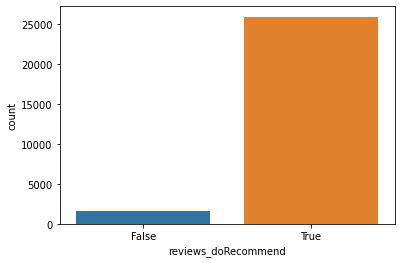

In [58]:
sns.countplot(x = 'reviews_doRecommend', data = df_clean)
plt.show()

Looking at the distribution of reviews_doRecommend column, we can see that more than 94% of the data is having True value. Hence, the column does not provide any useful information for the model to learn. We will drop this field

In [59]:
df_clean.drop(columns=['reviews_doRecommend'], inplace=True)


In [60]:
df_clean.shape

(30000, 11)

**Handling NULL values in reviews_title**

This column is an important component for our analysis as it contains the title of the review given by the user to a particular product. Since the NULL percentage is only 0.633%, we will remove these rows from the dataset.





In [61]:
df_clean = df_clean[~ df_clean.reviews_title.isna() ]
df_clean.shape


(29810, 11)

**Handling NULL values in reviews_username**

This column is an important component for our analysis as it contains the unique identification for individual user in the dataset. Since the NULL percentage is only 0.20%, we will remove these rows from the dataset.

In [62]:
df_clean = df_clean[~ df_clean.reviews_username.isna() ]
df_clean.shape

(29748, 11)

**Handling NULL values in user_sentiment**

In [63]:
df_clean.user_sentiment.value_counts()


Positive    26412
Negative     3335
Name: user_sentiment, dtype: int64

In [64]:
df_clean[ df_clean.user_sentiment.isna() ]


,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & TV,Disney,Blu-ray,Children & Family,Movies & Music,Movies & TV Shows,Electronics, Tech Toys, Movies, Music,Blu-Rays,See ALL Blu-Ray,Frys",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),2014-11-07T00:00:00.000Z,5,my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the poin...,a super hit with my children. they loved it!!??,7.87E+11,NaN


As there is only one record with missing data for user_sentiment, we will read the record manually and update the value.

From reading the review title and rating, we can see that the overall sentiment is positive. So, we will update the value as Positive for this particular record with NaN.

In [65]:
df_clean.user_sentiment.fillna('Positive', inplace=True)


As the columns manufacturer and reviews_date are not needed for both Sentiment and Recommender models we don't need to handle the NULL values for them.

In [66]:
# Check the data for top 5 rows
df_clean.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,Negative


### Analysis


Checking Distribution of *reviews_rating* column¶


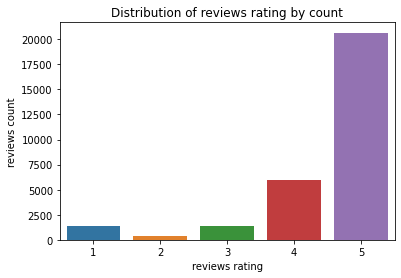

In [67]:
sns.countplot(x = 'reviews_rating', data = df_clean).set(title="Distribution of reviews rating by count", xlabel="reviews rating", ylabel="reviews count")
plt.show()
